In [1]:
!pip install -q xgboost catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [2]:
import re, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack


In [4]:
df = pd.read_csv("/content/complete_data.csv")   # set your path
df = df[['text','label']].dropna().reset_index(drop=True)

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#\w+", " ", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['clean'] = df['text'].apply(clean_text)


In [5]:
X = df['clean'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)


In [6]:
# Word-level TF-IDF (unigrams + bigrams)
tfidf_word = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=2, stop_words='english')

# Char-level TF-IDF (captures subword patterns & misspellings)
tfidf_char = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=5000, min_df=2)

# Fit transformers on train, transform both sets
Xw = tfidf_word.fit_transform(X_train)
Xc = tfidf_char.fit_transform(X_train)
X_train_feats = hstack([Xw, Xc])

Xw_test = tfidf_word.transform(X_test)
Xc_test = tfidf_char.transform(X_test)
X_test_feats = hstack([Xw_test, Xc_test])

print("Train features shape:", X_train_feats.shape)


Train features shape: (121, 2111)


In [9]:
# use SVD if you want smaller dense representation for models like k-NN or XGBoost
svd = TruncatedSVD(n_components=300, random_state=42)   # tune 100-400
X_train_svd = svd.fit_transform(X_train_feats)
X_test_svd  = svd.transform(X_test_feats)


In [11]:
# --- ensure imports present ---
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# 1) Fit LabelEncoder on full set of labels to keep mapping consistent
le = LabelEncoder()
le.fit(np.concatenate([y_train, y_test]))   # safe: uses all label values present
y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# 2) Re-train models with numeric labels
# ComplementNB on sparse TF-IDF (X_train_feats / X_test_feats)
nb = ComplementNB(alpha=0.3)
nb.fit(X_train_feats, y_train_enc)
pred_nb_enc = nb.predict(X_test_feats)
pred_nb = le.inverse_transform(pred_nb_enc)

print("NB acc:", accuracy_score(y_test, pred_nb))
print(classification_report(y_test, pred_nb))
print("Confusion matrix (NB):\n", confusion_matrix(y_test, pred_nb))

# k-NN on SVD (dense)
knn = KNeighborsClassifier(n_neighbors=7, metric='cosine', algorithm='brute')
knn.fit(X_train_svd, y_train_enc)
pred_knn_enc = knn.predict(X_test_svd)
pred_knn = le.inverse_transform(pred_knn_enc)

print("k-NN acc:", accuracy_score(y_test, pred_knn))
print(classification_report(y_test, pred_knn))
print("Confusion matrix (k-NN):\n", confusion_matrix(y_test, pred_knn))

# ExtraTrees on SVD
et = ExtraTreesClassifier(n_estimators=400, random_state=42, class_weight='balanced')
et.fit(X_train_svd, y_train_enc)
pred_et_enc = et.predict(X_test_svd)
pred_et = le.inverse_transform(pred_et_enc)

print("ExtraTrees acc:", accuracy_score(y_test, pred_et))
print(classification_report(y_test, pred_et))
print("Confusion matrix (ExtraTrees):\n", confusion_matrix(y_test, pred_et))

# XGBoost on SVD (now with numeric labels)
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=400, learning_rate=0.08, max_depth=6,
                    use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_svd, y_train_enc)
pred_xgb_enc = xgb.predict(X_test_svd)
pred_xgb = le.inverse_transform(pred_xgb_enc)

print("XGBoost acc:", accuracy_score(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb))
print("Confusion matrix (XGBoost):\n", confusion_matrix(y_test, pred_xgb))

# CatBoost (also accepts numeric labels)
from catboost import CatBoostClassifier
catb = CatBoostClassifier(iterations=400, learning_rate=0.08, depth=6, verbose=0, random_state=42)
catb.fit(X_train_svd, y_train_enc)
pred_catb_enc = catb.predict(X_test_svd)
# CatBoost predict sometimes returns shape (n,) or (n,1) with dtype float; ensure int
pred_catb_enc = np.array(pred_catb_enc).astype(int).reshape(-1)
pred_catb = le.inverse_transform(pred_catb_enc)

print("CatBoost acc:", accuracy_score(y_test, pred_catb))
print(classification_report(y_test, pred_catb))
print("Confusion matrix (CatBoost):\n", confusion_matrix(y_test, pred_catb))


Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
NB acc: 0.5802469135802469
              precision    recall  f1-score   support

    negative       0.61      0.41      0.49        27
     neutral       0.60      0.67      0.63        27
    positive       0.55      0.67      0.60        27

    accuracy                           0.58        81
   macro avg       0.59      0.58      0.57        81
weighted avg       0.59      0.58      0.57        81

Confusion matrix (NB):
 [[11  7  9]
 [ 3 18  6]
 [ 4  5 18]]
k-NN acc: 0.5061728395061729
              precision    recall  f1-score   support

    negative       0.57      0.30      0.39        27
     neutral       0.44      0.85      0.58        27
    positive       0.67      0.37      0.48        27

    accuracy                           0.51        81
   macro avg       0.56      0.51      0.48        81
weighted avg       0.56      0.51      0.48        81

Confusion matrix (k-NN):
 [[ 8 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:16:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost acc: 0.5802469135802469
              precision    recall  f1-score   support

    negative       0.59      0.59      0.59        27
     neutral       0.55      0.63      0.59        27
    positive       0.61      0.52      0.56        27

    accuracy                           0.58        81
   macro avg       0.58      0.58      0.58        81
weighted avg       0.58      0.58      0.58        81

Confusion matrix (XGBoost):
 [[16  8  3]
 [ 4 17  6]
 [ 7  6 14]]
CatBoost acc: 0.5925925925925926
              precision    recall  f1-score   support

    negative       0.62      0.59      0.60        27
     neutral       0.50      0.67      0.57        27
    positive       0.74      0.52      0.61        27

    accuracy                           0.59        81
   macro avg       0.62      0.59      0.59        81
weighted avg       0.62      0.59      0.59        81

Confusion matrix (CatBoost):
 [[16  9  2]
 [ 6 18  3]
 [ 4  9 14]]


In [12]:
!pip install -q tensorflow_text tensorflow_hub
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

X_train_emb = embed(X_train).numpy()
X_test_emb  = embed(X_test).numpy()


In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

et = ExtraTreesClassifier(n_estimators=500, random_state=42)
et.fit(X_train_emb, y_train_enc)
print("ExtraTrees + USE:", accuracy_score(y_test_enc, et.predict(X_test_emb)))

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_emb, y_train_enc)
print("LR + USE:", accuracy_score(y_test_enc, lr.predict(X_test_emb)))

cat = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.08, verbose=0)
cat.fit(X_train_emb, y_train_enc)
print("CatBoost + USE:", accuracy_score(y_test_enc, cat.predict(X_test_emb)))


ExtraTrees + USE: 0.8888888888888888
LR + USE: 0.8765432098765432
CatBoost + USE: 0.8888888888888888


In [14]:
preds_enc = et.predict(X_test_emb)
probs = et.predict_proba(X_test_emb)


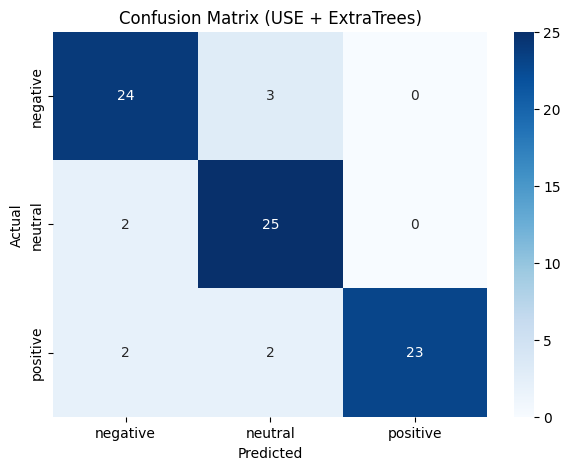

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Build confusion matrix
cm = confusion_matrix(y_test_enc, preds_enc)
labels = le.classes_  # original label names: ["negative","neutral","positive"]

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (USE + ExtraTrees)")
plt.show()


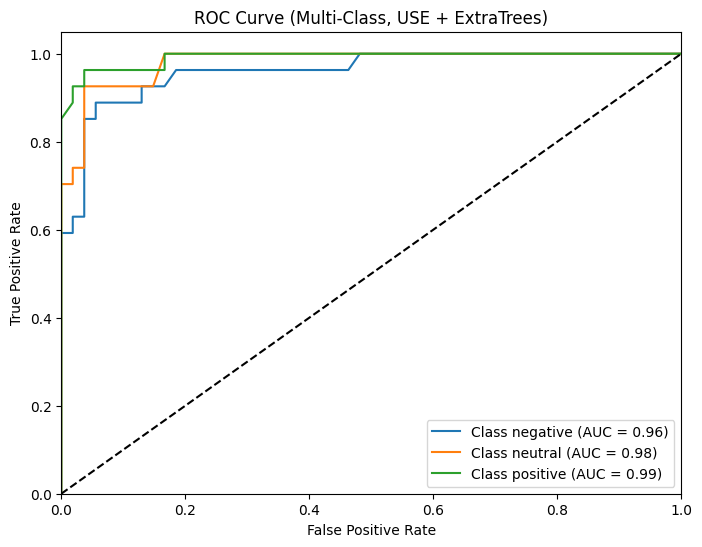

AUC Scores: {0: np.float64(0.9602194787379973), 1: np.float64(0.9807956104252401), 2: np.float64(0.9914266117969822)}


In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# number of classes
n_classes = len(le.classes_)

# Binarize labels for ROC
y_test_bin = label_binarize(y_test_enc, classes=range(n_classes))

# Compute ROC curve + AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

# Plot diagonal (chance line)
plt.plot([0, 1], [0, 1], "k--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-Class, USE + ExtraTrees)")
plt.legend(loc="lower right")
plt.show()

print("AUC Scores:", roc_auc)


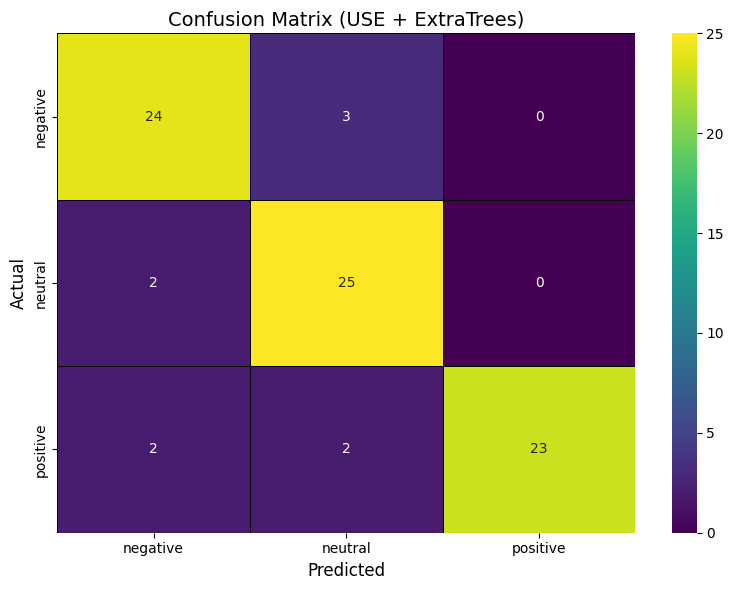

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure inline backend
%matplotlib inline

# Build CM
cm = confusion_matrix(y_test_enc, preds_enc)
labels = le.classes_

# Fresh figure + clear previous states
plt.figure(figsize=(8,6))
plt.clf()

ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.5,
    linecolor='black'
)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix (USE + ExtraTrees)", fontsize=14)
plt.tight_layout()
plt.show()
